# Environment Setup:
This notebook is intended to be run on Google Colab. You may complete the tasks offline, but at your own risk.

## Add dataset shortcut from your Google Account
Because of the size of the datasets, we are providing the files from Google Drive.

To access the provided data, go to [this link](https://drive.google.com/drive/folders/1_5LoxbmWDKPKi91Z_HmQn4TFoTtXnxQM?usp=sharing) and click "COMP4211_dataset->Organise->Add shortcut" to save a shortcut in your Google Drive "My Drive" folder (or any specific path in your google drive)

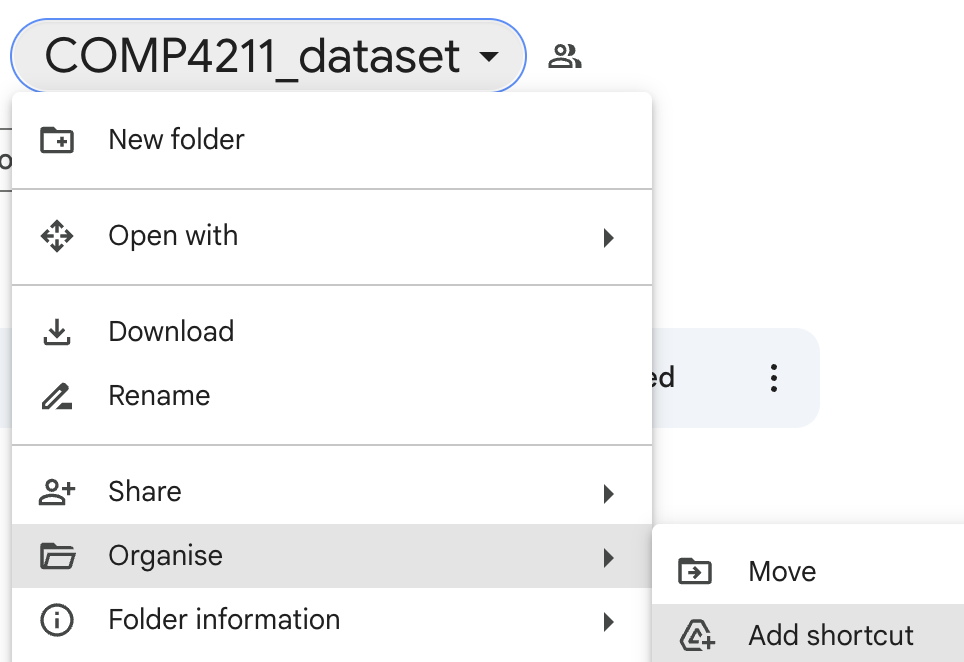

Mount the dataset by the following code (requires authorization):

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
data_path = "/content/drive/My Drive/COMP4211_dataset"
vgg_path = os.path.join(data_path, 'vgg19.npz')

pacs_zip = os.path.join(data_path, 'classify/pacs-dataset.zip')
wikiart_zip = os.path.join(data_path, 'wikiart.zip')
coco_zip = os.path.join(data_path, 'COCO.zip')

pacs_path = "classify"
wikiart_path = "wikiart"
coco_path = "COCO"


Mounted at /content/drive


To speed up the image loading, we unzip the training image datasets to the Google Colab VM rather than access it directly from Google Drive.

In [ ]:
!unzip "$wikiart_zip" > /dev/null 2>&1
!unzip "$coco_zip" > /dev/null 2>&1

(Tip: If you're only doing the second task, skip the above code to save a bit of time)

In [ ]:
# Put the PACS files in a subfolder
!mkdir -p "$pacs_path"
!unzip "$pacs_zip" -d "$pacs_path" > /dev/null 2>&1

## Preparation

This section contains imports and functions that will be used in the later tasks. Some of them are provided.

### Imports

In [ ]:
# Basic Libraries
import numpy as np
import pandas as pd
import tensorflow as tf

# Important submodules and functions from Tensorflow (and Keras)
from tensorflow.keras.layers import Input, Dense, Conv2D, UpSampling2D, Reshape, MaxPooling2D, Lambda, Layer, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import array_to_img

# Image handling and visualization
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from IPython.display import display
from tqdm.notebook import tqdm
import cv2

# Other utility
import datetime
import psutil


# Module settings:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # This will hide all TensorFlow messages, except for errors.
tf.get_logger().setLevel('ERROR')  # This sets TensorFlow logger to only output error messages.

### Utility Functions

**Preprocessing and Deprocessing Images**: In style transfer, images often need to be adjusted before and after passing through the model. The `preprocess` function converts images from RGB (used in most image formats) to BGR (used by the model) and normalizes pixel values by subtracting a mean value. This step helps in aligning the image data with the format expected by the VGG network, which our style transfer model is based on. Conversely, the `deprocess` function reverses these adjustments, converting the image back from BGR to RGB and adding the mean pixel values, making the output image suitable for viewing.

**Loading Images**: The `get_image` function reads an image from the disk, converts it to the RGB format, and optionally resizes it. This function is crucial for preparing your dataset for training or evaluation. It ensures that all images fed into the model are consistent in size and format.

**Finding Images**: The `find_images` function takes a directory path and a file type, and finds (recursively) all files within the directory that matches the file type. This is used for obtaining the images in the WikiArt and COCO dataset, as the images are put in different folders.

In [ ]:
# Prepares an image for the model by converting RGB to BGR and subtracting the mean pixel values.
def preprocess(x):
    img = tf.reverse(x, axis=[-1])  # RGB to BGR
    img -= np.array([103.939, 116.779, 123.68])  # Subtract mean pixel value
    return img

# Converts the output of the model back to a viewable image by adding mean pixel values and converting BGR to RGB.
def deprocess(x):
    img = x + np.array([103.939, 116.779, 123.68])  # Add mean pixel value
    img = tf.reverse(img, axis=[-1])  # BGR to RGB
    img = tf.clip_by_value(img, 0.0, 255.0)  # Ensure pixel value range is valid
    return img

# Loads an image from disk, optionally resizes it, and prepares it for the model.
def get_image(img_path, resize=True, shape=(256,256)):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB
    if resize:
        image = cv2.resize(image, shape)  # Resize image
    image = image.astype(np.float32)  # Convert to float32 for model compatibility
    return image

# Finds and returns a list of images (files) within a directory path that matches a certain file type.
def find_images(dir_path, file_type):
    image_paths = []

    for root, _, files in os.walk(dir_path):
        for file in files:
            if f'.{file_type}' in file:
                image_paths.append(os.path.join(root, file))

    return image_paths


### Datasets

This programming assignment requires 2 types of dataset, both used for loading images on-demand:

- `ImageDataset`, a dataset class that finds and collects image files within a given directory, and loads them for training. A single sample should only include the image bitmap (preprocessed using the above functions).
- `ClassificationDataset`, a dataset class that references a given `.tsv` file for file names and labels, and loads the images from the given directory along with the class label. A single sample should include the processed image bitmap, along with its class label in one-hot encoding.

In [ ]:
# [C1]
class ImageDataset:
    def __init__(self, dir_path, batch_size=8, file_type="jpg", random_state = 4211):
        # [Your code here]
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.file_type = file_type
        # self.random_state = random_state
        self.ds_pointer = 0
        self.data_paths = find_images(dir_path,file_type)
        np.random.seed(random_state)
        np.random.shuffle(self.data_paths)

    def reset_pointer(self, seed=None):
        # [Your code here]
        self.ds_pointer = 0
        np.random.seed(seed)
        np.random.shuffle(self.data_paths)

    def get_batch(self):
        # [Your code here]
        if self.ds_pointer+self.batch_size >= self.__len__():
          self.reset_pointer()
        batch = []
        for i in range(self.batch_size):
          # print(i)
          # print(self.ds_pointer)
          image = get_image(self.data_paths[self.ds_pointer+i])
          image = preprocess(image)
          batch.append(image)
          # print(image.shape)
        self.ds_pointer += self.batch_size
        return np.array(batch)


    def __len__(self):
        # [Your code here]
        return len(self.data_paths)

In [ ]:
# report the results of __len__ of COCO and WikiArt dataset
coco = ImageDataset(coco_path)
wikiArt = ImageDataset(wikiart_path)
print("__len__ of COCO dataset: {}".format(coco.__len__()))
print("__len__ of WikiArt dataset: {}".format(wikiArt.__len__()))
# b = coco.get_batch()
# print(b[0].shape)



__len__ of COCO dataset: 3557
__len__ of WikiArt dataset: 7492


In [ ]:
# Here's a preview of what the TSV would look like (top 10 rows):
!cat "$pacs_path/train-data.tsv" | head -n 10

pic_2524.jpg	sketch	dog
pic_888.jpg	sketch	dog
pic_1279.jpg	sketch	dog
pic_2694.jpg	sketch	dog
pic_79.jpg	sketch	dog
pic_650.jpg	sketch	dog
pic_2095.jpg	sketch	dog
pic_481.jpg	sketch	dog
pic_332.jpg	sketch	dog
pic_1417.jpg	sketch	dog


In [ ]:
# [C2]
class ClassificationDataset:
    def __init__(self, tsv_path, dir_path, batch_size=8, random_state = 4211):
        # [Your code here]
        self.tsv_path = tsv_path
        self.dir_path = dir_path
        self.batch_size = batch_size
        # self.random_state = random_state
        self.ds_pointer = 0
        self.tsv, self.data_paths = self._process_tsv(tsv_path,dir_path)
        self.num_class = len(pd.unique(self.tsv['classification']))
        # display(self.tsv)
        np.random.seed(random_state)
        np.random.shuffle(self.data_paths)
    # Tip: It is recommended to use this method to process the tsv data into a data table, since this will be used in both __init__() and add_data().
    def _process_tsv(self, tsv_path, dir_path):

        tsv = pd.read_csv(tsv_path,delimiter="\t",names=["file_name","style","classification"])
        paths = find_images(dir_path,"jpg")
        clas = pd.DataFrame(tsv["classification"])
        # print(type(clas))
        # print(type(tsv))
        df_encoded = pd.get_dummies(tsv,columns=["classification",])
        # display(clas)
        # display(df_encoded)
        df_encoded.insert(loc=2,column="classification",value=clas)
        # display(df_encoded)
        return df_encoded,paths

    def add_data(self, tsv_path, dir_path):
        # [Your code here]
        new_tsv,new_image_paths = self._process_tsv(tsv_path,dir_path)
        self.tsv = pd.concat([self.tsv,new_tsv],axis=0)
        for path in new_image_paths:

          self.data_paths.append(path);
        self.reset_pointer();

    def reset_pointer(self, seed=None):
        # [Your code here]
        self.ds_pointer = 0
        np.random.seed(seed)
        np.random.shuffle(self.data_paths)

    def get_batch(self):
        # [Your code here]
        if self.ds_pointer+self.batch_size >= self.__len__():
          self.reset_pointer()
        batch_path=[]
        batch_images = [] # The images will be return
        image_names = [] # The image names
        for i in range(self.batch_size):
          batch_path.append(self.data_paths[self.ds_pointer+i])

        batch_path.sort()
        for i in range(self.batch_size):
          image = get_image(batch_path[i])
          image = preprocess(image)
          batch_images.append(image)
          splited_str = batch_path[i].split("/")

          image_names.append(splited_str[-1])
        batch_tsv = self.tsv.loc[self.tsv['file_name'].isin(image_names)]
        batch_tsv = batch_tsv.sort_values(by=["file_name"])
        self.ds_pointer += self.batch_size
        return batch_tsv.iloc[:,3:],np.array(batch_images)

    def __len__(self):
        # [Your code here]
        return len(self.data_paths)

In [ ]:
train = ClassificationDataset(pacs_path+"/train-data.tsv",pacs_path+"/train-files")
test = ClassificationDataset(pacs_path+"/test-data.tsv",pacs_path+"/test-files")
print("__len__ of training dataset: {}".format(train.__len__()))
print("__len__ of test dataset: {}".format(test.__len__()))


__len__ of training dataset: 1641
__len__ of test dataset: 2723


## Part 1: Style Transfer


### Model Components

In [ ]:
class AdaIN(Layer):
    """
    Adaptive Instance Normalization (AdaIN) layer with controllable style transfer intensity.
    This layer adjusts the mean and variance of the content features to match those of the style features,
    then blends the result with the original content features based on a specified alpha value.
    """
    def __init__(self, epsilon=1e-5, **kwargs):
        super(AdaIN, self).__init__(**kwargs)
        self.epsilon = epsilon  # Small constant to avoid division by zero.

    def call(self, inputs):
        content, style, alpha = inputs

        # Compute mean and variance for content and style features.
        meanC, varC = tf.nn.moments(content, [1, 2], keepdims=True)
        meanS, varS = tf.nn.moments(style, [1, 2], keepdims=True)

        # Standard deviation is the square root of variance, adjusted with epsilon for numerical stability.
        sigmaC = tf.sqrt(varC + self.epsilon)
        sigmaS = tf.sqrt(varS + self.epsilon)

        # Perform AdaIN by normalizing content features and scaling them by style's standard deviation and mean.
        normalized_content = (content - meanC) / sigmaC
        stylized_content = normalized_content * sigmaS + meanS

        # Blend stylized content with original content based on alpha.
        blended_content = alpha * stylized_content + (1 - alpha) * content
        return blended_content

In [ ]:
def build_vgg19_enc(input_shape, weights_path):
    weights = np.load(weights_path)

    # [C3] Create vgg19 structure
    # [Your code here]
    model = Sequential(
        [
            Input(shape=input_shape),
            Conv2D(filters=64,kernel_size=(3,3),padding='same',activation="relu",name="conv1_1"),
            Conv2D(filters=64,kernel_size=(3,3),padding='same',activation="relu",name="conv1_2"),
            MaxPooling2D(pool_size=(2,2),strides=2,name="pool1"),
            Conv2D(filters=128,kernel_size=(3,3),padding='same',activation="relu",name="conv2_1"),
            Conv2D(filters=128,kernel_size=(3,3),padding='same',activation="relu",name="conv2_2"),
            MaxPooling2D(pool_size=(2,2),strides=2,name="pool2"),
            Conv2D(filters=256,kernel_size=(3,3),padding='same',activation="relu",name="conv3_1"),
            Conv2D(filters=256,kernel_size=(3,3),padding='same',activation="relu",name="conv3_2"),
            Conv2D(filters=256,kernel_size=(3,3),padding='same',activation="relu",name="conv3_3"),
            Conv2D(filters=256,kernel_size=(3,3),padding='same',activation="relu",name="conv3_4"),
            MaxPooling2D(pool_size=(2,2),strides=2,name="pool3"),
            Conv2D(filters=512,kernel_size=(3,3),padding='same',activation="relu",name="conv4_1"),
        ]
    )


    # [C4] Load in weights and freeze the model
    # [Your code here]
    kernels = []
    biases = []
    for i in range(0,18,2):
        kernel = weights["arr_{}".format(i)]
        bias = weights["arr_{}".format(i+1)]
        kernel = kernel.transpose([2,3,1,0])
        kernel = kernel.astype(np.float32)
        bias = bias.astype(np.float32)
        kernels.append(kernel)
        biases.append(bias)

    layer_index = int(0)

    for layer in model.layers:
        if layer.name.startswith("conv"):
            layer.set_weights([kernels[layer_index],biases[layer_index]])
            layer_index+=1

    model.trainable = False

    return model

def build_vgg19_relus(vgg19):
    relus = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1']
    features = [vgg19.get_layer(relu).output for relu in relus]
    vgg19_relus = Model(inputs=vgg19.input, outputs=features)
    vgg19_relus.trainable = False
    return vgg19_relus

# [C5]
def build_decoder(input_shape):
  # [Your code here]
    return Sequential(
        [
            Input(shape=input_shape),
            Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu'),
            UpSampling2D(size=(2,2)),
            Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu'),
            Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu'),
            Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu'),
            Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'),
            UpSampling2D(size=(2,2)),
            Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'),
            Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'),
            UpSampling2D(size=(2,2)),
            Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'),
            Conv2D(filters=3,kernel_size=(3,3),padding='same')
        ]
    )


def build_model(encoder, decoder, input_shape):
    content = Input(shape=input_shape, name='content')
    style = Input(shape=input_shape, name = 'style')
    alpha = Input(shape=(1,), name='alpha')

    enc_content = encoder(content)
    enc_style = encoder(style)
    # print(enc_style.shape)
    adain = AdaIN()([enc_content, enc_style, alpha])

    out = decoder(adain)

    return Model(inputs=[content, style, alpha], outputs=[out, adain])


In [ ]:
encoder = build_vgg19_enc((256,256,3),vgg_path)
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 256, 256, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 256, 256, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 128, 128, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 128, 128, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 128, 128, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 64, 64, 128)       0         
                                                                 
 conv3_1 (Conv2D)            (None, 64, 64, 256)       2

In [ ]:
decoder = build_decoder((32,32,512))
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 256)       1179904   
                                                                 
 up_sampling2d (UpSampling2  (None, 64, 64, 256)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 256)       590080    
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 256)       590080    
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 256)       590080    
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 128)       295040    
                                                      

In [ ]:
def get_loss(encoder, vgg19_relus, epsilon=1e-5, style_weight=1.0):

    def loss(y_true, y_pred):
        out, adain = y_pred[0], y_pred[1]

        # Encode output and compute content_loss
        out = deprocess(out)
        out = preprocess(out)
        enc_out = encoder(out)
        content_loss = tf.reduce_sum(tf.reduce_mean(tf.square(enc_out - adain), axis=[1, 2]))

        # Compute style loss from vgg relus
        style = y_true[1]
        style_featues = vgg19_relus(style)
        gen_features = vgg19_relus(out)
        style_layer_loss = []
        for enc_style_feat, enc_gen_feat in zip(style_featues, gen_features):
            meanS, varS = tf.nn.moments(enc_style_feat, [1, 2])
            meanG, varG = tf.nn.moments(enc_gen_feat,   [1, 2])

            sigmaS = tf.sqrt(varS + epsilon)
            sigmaG = tf.sqrt(varG + epsilon)

            l2_mean  = tf.reduce_sum(tf.square(meanG - meanS))
            l2_sigma = tf.reduce_sum(tf.square(sigmaG - sigmaS))

            style_layer_loss.append(l2_mean + l2_sigma)

        style_loss = tf.reduce_sum(style_layer_loss)

        # Compute the total loss
        weighted_style_loss = style_weight * style_loss
        total_loss = content_loss + weighted_style_loss
        return total_loss, content_loss, weighted_style_loss

    return loss

### Training Routine

In [ ]:
# [C6]
def part1_train(model, content_ds, style_ds, loss_fn, n_epochs = 10, save_interval = 1, save_path=None, load_path=None):
    # Initialize the Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,weight_decay=5e-5) # [Your code here]

    # Calculate the number of batches per epoch
    n_batches = max(content_ds.__len__()//content_ds.batch_size, style_ds.__len__()//style_ds.batch_size) # [Your code here]

    # Initialize other things
    process = psutil.Process(os.getpid())
    alpha = 1.0

    # Load weights if provided
    if load_path:
        model.load_weights(load_path)

    # Run for n epochs
    for e in range(1, n_epochs+1):
        pbar = tqdm(total=n_batches)
        # Reset Dataset Iterators
        # [Your code here]
        content_ds.reset_pointer()
        style_ds.reset_pointer()

        # Define Loss Metrics. To be updated in each batch
        losses = {"total": 0.0, "content": 0.0, "style": 0.0}

        # Run for all batches
        for i in range(n_batches):
            # Fetch Training Batches
            # [Your code here]
            content_batch = content_ds.get_batch()
            style_batch = style_ds.get_batch()

            # Execute Batch Training
            # Tip: Use tf.GradientTape() when computing the loss, to obtain the gradient.
            # [Your code here]
            with tf.GradientTape() as g:
              g.watch(model.trainable_variables)
              output = model([content_batch,style_batch,alpha])
              total_loss,content_loss,weighted_style_loss = loss_fn([content_batch,style_batch],output)
            gradient = g.gradient(total_loss,model.trainable_variables)
            optimizer.apply_gradients(zip(gradient,model.trainable_variables))
            # Update Loss Metrics
            # [Your code here]
            losses["total"] = (losses["total"]*i+total_loss)/(i+1)
            losses["content"] = (losses["content"]*i+content_loss)/(i+1)
            losses["style"] = (losses["style"]*i+weighted_style_loss)/(i+1)

            # Visualize loss during training
            string = "".join([f"{key} loss: {value:.3f}\t" for key, value in losses.items()])
            pbar.set_description(f"Epoch {e}/{n_epochs}\t" + string)
            pbar.update(1)

        # In case the session ends before the training is done, perform a save on the model from time to time:
        if e % save_interval == 0:
            if save_path:
                model.save(save_path)

### Model setup

In [ ]:
def part1_prepare_datasets():
    #####
    # MODIFY SETTINGS HERE
    #####
    BATCH_SIZE = 16 # Recommended according to the Google Colab T4 GPU

    content_ds = ImageDataset(coco_path, batch_size=BATCH_SIZE)
    style_ds = ImageDataset(wikiart_path, batch_size=BATCH_SIZE)

    return content_ds, style_ds

def part1_setup():
    #####
    # MODIFY SETTINGS HERE
    #####
    STYLE_WEIGHT = 2.0
    EPSILON = 1e-5

    INPUT_SHAPE = (None, None, 3) # We accept any image size

    # Build model
    vgg19 = build_vgg19_enc(INPUT_SHAPE, vgg_path)  # encoder
    decoder = build_decoder(vgg19.output.shape[1:])  # input shape == encoder output shape
    model = build_model(vgg19, decoder, INPUT_SHAPE)

    # Get loss
    vgg19_relus = build_vgg19_relus(vgg19)
    loss = get_loss(vgg19, vgg19_relus, epsilon=EPSILON, style_weight=STYLE_WEIGHT)

    return model, loss

In [ ]:
content_ds, style_ds = part1_prepare_datasets()

In [ ]:
model, loss = part1_setup()

We can now start the training:

In [ ]:
#####
# We recommend you to save on your mounted Google Drive folder,
# otherwise it may get lost after the Colab session terminated
#####
PART1_SAVE_PATH = "/content/drive/MyDrive/comp4211_pa2/saved.h5" # Change to your own path.

part1_train(model, content_ds, style_ds, loss, n_epochs=5, save_path=PART1_SAVE_PATH)

In [ ]:
# To continue to train the saved weights, do this:
PART1_LOAD_PATH = '/content/drive/MyDrive/comp4211_pa2/saved.h5' # Change to your own path

part1_train(model, content_ds, style_ds, loss, n_epochs=1, save_path=PART1_SAVE_PATH, load_path=PART1_LOAD_PATH)

Note: Due to the limited computing time available in Colab, it may be a good idea to divide the training into different sessions, by saving and loading the model weights in your Google Drive.  

Do not save the weights outside the drive or they will be deleted after the session ends!

### Inference

In [ ]:
# [C7]
def part1_inference(model_path, content_path, style_path, alpha):
  model = load_model(model_path, custom_objects={'AdaIN': AdaIN})

  # Get content image
  # [Your code here]
  content_image = get_image(content_path)[np.newaxis,:,:,:]
  content_image = preprocess(content_image)

  # Get style image
  # [Your code here]
  style_image = get_image(style_path)[np.newaxis,:,:,:]
  style_image = preprocess(style_image)
  # Set alpha Value
  # [Your code here]
  tensor_alpha = np.array([alpha])
  # Do inference
  # [Your code here]
  y,_ = model.predict([content_image,style_image,tensor_alpha])

  # Convert output array to image
  # [Your code here]
  y = np.squeeze(y,axis=0)
  y = deprocess(y)
  img = array_to_img(y)

  # Display the image in the Notebook
  display(img)

1/1 [==============================] - 5s 5s/step


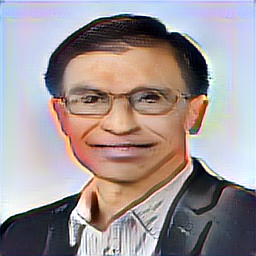

In [ ]:
#####
# MODIFY SETTINGS HERE
#####
ALPHA = 0.7
MODEL_PATH = PART1_SAVE_PATH
# Here below is a sample, please change to your own path
CONTENT_PATH = os.path.join(data_path, 'HKUST/dyyeung.jpg')
# Here below is a sample, please change to your own path
STYLE_PATH = os.path.join(data_path, '/content/wikiart/Pop_Art/andy-warhol_goethe.jpg')


part1_inference(MODEL_PATH, CONTENT_PATH, STYLE_PATH, ALPHA)

1/1 [==============================] - 0s 387ms/step


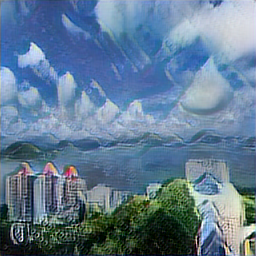

In [ ]:
# Another sample, please change and test on your own
ALPHA=0.5
CONTENT_PATH = os.path.join(data_path, 'HKUST/7.jpeg')
MODEL_PATH = PART1_SAVE_PATH
STYLE_PATH = os.path.join(data_path, 'Extra_styles/the-starry-night.jpg')
part1_inference(MODEL_PATH, CONTENT_PATH, STYLE_PATH, ALPHA)

## Part 2: Classification Task

The second part of this assignment is a Classification Task, but with an unideal training dataset.

This task uses the PACS dataset (an image dataset with images of different categories and in different styles), but modified to have an abnormal distribution between styles and categories.

### Analyzing the dataset

Before we start the classification task, let's load and obtain some basic info about our training dataset.

In [ ]:
def part2_prepare_datasets():
    #####
    # MODIFY SETTINGS HERE
    #####
    BATCH_SIZE = 64
    TRAIN_DS_PATH = os.path.join(pacs_path, "train-files/")
    TRAIN_TSV_PATH = os.path.join(pacs_path, "train-data.tsv")
    TEST_DS_PATH = os.path.join(pacs_path, "test-files/")
    TEST_TSV_PATH = os.path.join(pacs_path, "test-data.tsv")

    train_ds = ClassificationDataset(TRAIN_TSV_PATH, TRAIN_DS_PATH, batch_size = BATCH_SIZE)
    test_ds = ClassificationDataset(TEST_TSV_PATH, TEST_DS_PATH, batch_size = BATCH_SIZE)

    return train_ds, test_ds

train_ds, test_ds = part2_prepare_datasets()

Find out the distribution of images in diferent styles and categories:

In [ ]:
# [C8]
def part2_tally_samples(dataset):
    # [Your code here]
    styles = pd.unique(dataset.tsv['style'])
    styles.sort()
    labels = pd.unique(dataset.tsv['classification'])
    labels.sort()
    for s in styles:
      for l in labels:
        num_samples_style = dataset.tsv.loc[dataset.tsv['style']==s]
        # display(num_samples_style)
        num_samples = num_samples_style.loc[num_samples_style['classification']==l]
        # display(num_samples)
        print("({},{}): {}".format(s,l,len(num_samples)))
      print()

part2_tally_samples(train_ds)

(art_painting,dog): 13
(art_painting,elephant): 13
(art_painting,giraffe): 231
(art_painting,guitar): 10
(art_painting,horse): 180
(art_painting,house): 11
(art_painting,person): 11

(cartoon,dog): 10
(cartoon,elephant): 13
(cartoon,giraffe): 12
(cartoon,guitar): 121
(cartoon,horse): 11
(cartoon,house): 12
(cartoon,person): 12

(photo,dog): 10
(photo,elephant): 13
(photo,giraffe): 12
(photo,guitar): 10
(photo,horse): 11
(photo,house): 215
(photo,person): 211

(sketch,dog): 229
(sketch,elephant): 217
(sketch,giraffe): 10
(sketch,guitar): 9
(sketch,horse): 8
(sketch,house): 13
(sketch,person): 13



Compare this to the test dataset:

In [ ]:
part2_tally_samples(test_ds)

(art_painting,dog): 119
(art_painting,elephant): 89
(art_painting,giraffe): 110
(art_painting,guitar): 82
(art_painting,horse): 90
(art_painting,house): 110
(art_painting,person): 96

(cartoon,dog): 95
(cartoon,elephant): 83
(cartoon,giraffe): 109
(cartoon,guitar): 82
(cartoon,horse): 81
(cartoon,house): 101
(cartoon,person): 95

(photo,dog): 81
(photo,elephant): 83
(photo,giraffe): 102
(photo,guitar): 81
(photo,horse): 103
(photo,house): 95
(photo,person): 110

(sketch,dog): 112
(sketch,elephant): 115
(sketch,giraffe): 104
(sketch,guitar): 95
(sketch,horse): 108
(sketch,house): 80
(sketch,person): 112



### Main Implementation

The architecture of the classification model is also a VGG19 model, adapted for multiclass classification.

In [ ]:
# [C9]
def build_vgg19_classifier(input_shape, num_class):

    model = Sequential(
        [
            Input(shape=input_shape),
            Conv2D(filters=64,kernel_size=(3,3),padding='same',activation="relu",name="conv1_1"),
            Conv2D(filters=64,kernel_size=(3,3),padding='same',activation="relu",name="conv1_2"),
            MaxPooling2D(pool_size=(2,2),strides=2,name="pool1"),
            Conv2D(filters=128,kernel_size=(3,3),padding='same',activation="relu",name="conv2_1"),
            Conv2D(filters=128,kernel_size=(3,3),padding='same',activation="relu",name="conv2_2"),
            MaxPooling2D(pool_size=(2,2),strides=2,name="pool2"),
            Conv2D(filters=256,kernel_size=(3,3),padding='same',activation="relu",name="conv3_1"),
            Conv2D(filters=256,kernel_size=(3,3),padding='same',activation="relu",name="conv3_2"),
            Conv2D(filters=256,kernel_size=(3,3),padding='same',activation="relu",name="conv3_3"),
            Conv2D(filters=256,kernel_size=(3,3),padding='same',activation="relu",name="conv3_4"),
            MaxPooling2D(pool_size=(2,2),strides=2,name="pool3"),
            Conv2D(filters=512,kernel_size=(3,3),padding='same',activation="relu",name="conv4_1"),
            GlobalAveragePooling2D(name="global_pool"),
            Dense(units=1024,activation='relu',name="dense1"),
            Dense(units=1024,activation='relu',name="dense2"),
            Dense(units=512,activation='relu',name="dense3"),
            Dense(units=num_class,activation='softmax',name="dense4")
        ]

    )

    return model

In [ ]:
class_model = build_vgg19_classifier((256,256,3),7)
class_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 256, 256, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 256, 256, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 128, 128, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 128, 128, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 128, 128, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 64, 64, 128)       0         
                                                                 
 conv3_1 (Conv2D)            (None, 64, 64, 256)      

In [ ]:
# [This part is not graded but is required for successful completion of other tasks]
def part2_setup(LOAD_PATH = None):
    INPUT_SHAPE = (None, None, 3)

    # Build model
    # [Your code here]
    # img = Input(shape=INPUT_SHAPE,name='img')

    model = build_vgg19_classifier(input_shape=INPUT_SHAPE,num_class=7)

    # Get Loss
    loss_fn = tf.keras.losses.CategoricalCrossentropy() # [Your code here]

    if LOAD_PATH:
        model.load_weights(LOAD_PATH)

    return model, loss_fn

model2, loss2 = part2_setup()

### Training the model with the given dataset

In [ ]:
# [C10]
def part2_train(model, dataset, loss_fn, n_epochs = 100, save_interval = 10, save_path=None, load_path=None):
    # Initialize the Optimizer
    optimizer = tf.keras.optimizers.Adam() # [Your code here]

    # Calculate the number of batches per epoch
    n_batches = len(dataset)//dataset.batch_size # [Your code here]

    # Initialize other things
    process = psutil.Process(os.getpid())

    # Load weights if provided
    if load_path:
        model.load_weights(load_path)

    # Run for n epochs
    for e in range(1, n_epochs+1):
        pbar = tqdm(total=n_batches)
        # Reset Dataset Iterators
        # [Your code here]
        dataset.reset_pointer()
        # Define Loss Metrics. To be updated in each batch
        losses = {"cross-entropy": 0.0}

        # Run for all batches
        for i in range(n_batches):
            # Fetch Training Batches
            # [Your code here]
            labels,images = dataset.get_batch()
            # Execute Batch Training
            # [Your code here]
            with tf.GradientTape() as g:
              g.watch(model.trainable_variables)
              output = model(images)
              class_loss = loss_fn(labels,output)
            gradient = g.gradient(class_loss,model.trainable_variables)
            optimizer.apply_gradients(zip(gradient,model.trainable_variables))
            # Update Loss Metrics
            # [Your code here]
            losses["cross-entropy"] = (losses["cross-entropy"]*i+class_loss)/(i+1)
            # Visualize loss during training
            string = "".join([f"{key} loss: {value:.3f}\t" for key, value in losses.items()])
            pbar.set_description(f"Epoch {e}/{n_epochs}\t" + string)
            pbar.update(1)

        # In case the session ends before the training is done, perform save the model from time to time:
        if e % save_interval == 0:
            if save_path:
                model.save(save_path)


In [ ]:
PART2_SAVE_PATH = "/content/drive/MyDrive/comp4211_pa2/classify.h5"

In [ ]:
# Train the model
PART2_SAVE_PATH = "/content/drive/MyDrive/comp4211_pa2/classify.h5" # [Change to your own path]

# [Call your train function here]
# part2_train(model2, train_ds, loss2, n_epochs = 100, save_interval = 10, save_path=PART2_SAVE_PATH, load_path=None)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

### Testing

We can now test our first classifier model with the test dataset (maybe train dataset too, to make sure the training went properly).

Calculate the accuracy of the model, as well as the confusion matrix to for a clearer idea on the model's performance:

In [ ]:
# [C11]
def part2_evaluate(model, dataset):
    # [Your code here]

    original_batch_size = dataset.batch_size
    dataset.reset_pointer()
    dataset.batch_size = len(dataset)
    all_label,all_image = dataset.get_batch()
    dataset.batch_size = original_batch_size
    all_pred = model.predict(all_image)

    m = tf.keras.metrics.CategoricalAccuracy()
    m.reset_state()
    m.update_state(all_label,all_pred)
    acc = m.result()
    print("Accuracy: {}".format(acc))

    label_encoded = tf.math.argmax(all_label,1)
    pred_encoded = tf.math.argmax(all_pred,1)
    confusion = tf.math.confusion_matrix(label_encoded,pred_encoded,num_classes=dataset.num_class)
    print("Confusion matrix:")
    print(confusion)



In [ ]:
model = load_model(PART2_SAVE_PATH)
print("Training dataset:")
part2_evaluate(model, train_ds)

Training dataset:
52/52 [==============================] - 13s 147ms/step
Accuracy: 1.0
Confusion matrix:
tf.Tensor(
[[262   0   0   0   0   0   0]
 [  0 256   0   0   0   0   0]
 [  0   0 265   0   0   0   0]
 [  0   0   0 150   0   0   0]
 [  0   0   0   0 210   0   0]
 [  0   0   0   0   0 251   0]
 [  0   0   0   0   0   0 247]], shape=(7, 7), dtype=int32)


In [ ]:
print("Test dataset:")
part2_evaluate(model, test_ds)


Test dataset:
86/86 [==============================] - 10s 122ms/step
Accuracy: 0.4572162926197052
Confusion matrix:
tf.Tensor(
[[165  32  55  29  95  10  21]
 [ 63 153  49   8  59  19  19]
 [ 92   8 224  29  44  13  15]
 [ 86   9  35 122  49  10  29]
 [115  26  20  21 172  14  14]
 [ 23  18  66   8  23 233  15]
 [ 80  29  41  24  54   9 176]], shape=(7, 7), dtype=int32)


In [ ]:
test_ds.reset_pointer()
tsv_batch,img_batch = test_ds.get_batch()
pred_batch = model.predict(img_batch)
tsv_batch_encoded = tf.math.argmax(tsv_batch,1)
pred_batch_encoded = tf.math.argmax(pred_batch,1)
print("Label classes:")
print(tsv_batch_encoded)
print("Reported classes:")
print(pred_batch_encoded)

2/2 [==============================] - 0s 108ms/step
Label classes:
tf.Tensor(
[6 5 4 0 1 5 2 6 4 6 1 1 0 4 4 2 6 6 3 2 2 3 3 4 6 3 3 3 5 1 6 3 2 3 5 5 1
 3 5 1 3 2 3 2 0 5 0 2 5 5 2 3 5 4 4 6 2 1 2 1 3 0 6 0], shape=(64,), dtype=int64)
Reported classes:
tf.Tensor(
[4 5 4 0 5 2 2 2 4 0 0 1 0 6 4 2 6 1 0 0 1 3 6 3 5 3 1 0 5 4 1 0 2 0 1 1 1
 6 5 1 3 2 6 2 3 5 0 2 2 1 0 6 5 4 4 0 2 1 0 1 2 0 4 2], shape=(64,), dtype=int64)


Label: person, Reported: horse


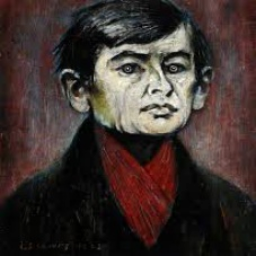

Label: elephant, Reported: house


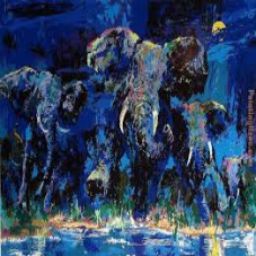

Label: house, Reported: giraffe


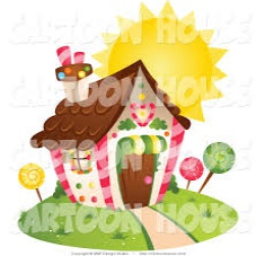

In [ ]:
index = [0,4,5]
for i in index:
  # img = get_image(test.data_paths[i])
  label_index = int(tsv_batch_encoded[i])
  reported_index = int(pred_batch_encoded[i])
  # print(label_index)
  # print(reported_index)
  print("Label: {}, Reported: {}".format(tsv_batch.columns[label_index][15:],tsv_batch.columns[reported_index][15:]))
  img = img_batch[i]
  img = deprocess(img)
  img = array_to_img(img)
  display(img)

### Data Augmentation with Style Transfer

In [ ]:
# [C12]
def part2_transfer(model, dataset, content_idx, style_idx, alpha):
    # [Your code here]
    # Tip: A large part of part1_inference can be applied here.

    content_fn = dataset.tsv.iloc[content_idx,0]
    # print(content_fn)
    dataset.reset_pointer()
    for i in dataset.data_paths:
      if content_fn in i:
        content_path = i
        content_image = get_image(content_path)[np.newaxis,:,:,:]
        content_image = preprocess(content_image)
        break


    style_fn = dataset.tsv.iloc[style_idx,0]
    # print(style_fn)
    for i in dataset.data_paths:
      if style_fn in i:
        style_path = i
        style_image = get_image(style_path)[np.newaxis,:,:,:]
        style_image = preprocess(style_image)
        break

    tensor_alpha = np.array([alpha])

    y,_ = model.predict([content_image,style_image,tensor_alpha])
    y = np.squeeze(y,axis=0)
    y = deprocess(y)
    img = array_to_img(y)
    # Instead of displaying the image, return it to be saved:
    return img

In [ ]:
ALPHA = 0.7

In [ ]:
# [C12]
def part2_augment(part1_load_path, dataset, output_tsv, output_dir, samples_per_pair = 50, alpha = ALPHA, random_state = 4211):
    # We don't want to reload the model for every single sample,
    # so we load one here and pass it to the transfer function:
    model = load_model(PART1_LOAD_PATH,custom_objects={'AdaIN': AdaIN}) # [Your code here]

    # Get label and style samples to transfer from
    # These are expected to be in the form of
    # { "(label/style name)": [(list of indices in the dataset that corresponds to the label/style)], ... }
    # Tip: If you can have a pandas Dataframe from the dataset, you can use groupby(...).indices here.
    labeldict = dataset.tsv.groupby("classification").indices # [Your code here]
    styledict = dataset.tsv.groupby("style").indices # [Your code here]

    # Generate random samples
    rng = np.random.default_rng(random_state)
    derived_tsv = "" # For usage in ClassificationDataset
    pair_set = set() # To prevent generating duplicates
    for label, label_idxs in labeldict.items():
        for style, style_idxs in styledict.items():
            for i in range(samples_per_pair):
                pair = None
                while not pair or pair in pair_set:
                    pair = rng.choice(label_idxs), rng.choice(style_idxs)
                pair_set.add(pair)

                # Generate 1 sample
                img = part2_transfer(model, dataset, pair[0], pair[1], alpha)

                # Make up a name for the same sample. Don't repeat the names!
                derived_name = str(label)+str(style)+str(i)+".jpg" # [Your code here]
                # Add an entry to the TSV file. Follow the format of "train-data.tsv" and "test-data.tsv"!
                derived_entry = "{}\t{}\t{}\n".format(derived_name,style,label) # [Your code here]

                # Save the image in the given folder
                img.save(os.path.join(output_dir, derived_name))
                # Add entry to the TSV to be written
                derived_tsv += derived_entry

    # Write the entries into the given file name
    with open(output_tsv, "w") as f:
        f.write(derived_tsv)


In [ ]:
PART1_MODEL_PATH = os.path.join(data_path, 'saved.h5') # [Change to your part_1 saved weight]
ALPHA = 0.75

OUTPUT_TSV = "classify/derived-data.tsv"
OUTPUT_DIR = "classify/derived-files"

# Before running the augmentation, it is a good idea to prepare an empty directory for the generated outputs:
def part2_cleanup_augments(output_dir):
    !rm -rf "$output_dir"
    !mkdir -p "$output_dir"

In [ ]:
!cat "$OUTPUT_TSV"

cat: classify/derived-data.tsv: No such file or directory


In [ ]:
# Generate the dataset:
part2_cleanup_augments(OUTPUT_DIR)
part2_augment(PART1_MODEL_PATH, train_ds, OUTPUT_TSV, OUTPUT_DIR, samples_per_pair = 50, alpha = ALPHA, random_state = 4211)

1/1 [==============================] - 0s 21ms/step


In [ ]:
!cat "$OUTPUT_TSV"

dogart_painting0.jpg	art_painting	dog
dogart_painting1.jpg	art_painting	dog
dogart_painting2.jpg	art_painting	dog
dogart_painting3.jpg	art_painting	dog
dogart_painting4.jpg	art_painting	dog
dogart_painting5.jpg	art_painting	dog
dogart_painting6.jpg	art_painting	dog
dogart_painting7.jpg	art_painting	dog
dogart_painting8.jpg	art_painting	dog
dogart_painting9.jpg	art_painting	dog
dogart_painting10.jpg	art_painting	dog
dogart_painting11.jpg	art_painting	dog
dogart_painting12.jpg	art_painting	dog
dogart_painting13.jpg	art_painting	dog
dogart_painting14.jpg	art_painting	dog
dogart_painting15.jpg	art_painting	dog
dogart_painting16.jpg	art_painting	dog
dogart_painting17.jpg	art_painting	dog
dogart_painting18.jpg	art_painting	dog
dogart_painting19.jpg	art_painting	dog
dogart_painting20.jpg	art_painting	dog
dogart_painting21.jpg	art_painting	dog
dogart_painting22.jpg	art_painting	dog
dogart_painting23.jpg	art_painting	dog
dogart_painting24.jpg	art_painting	dog
dogart_painting25.jpg	art_painting	

classify/derived-files/houseart_painting46.jpg


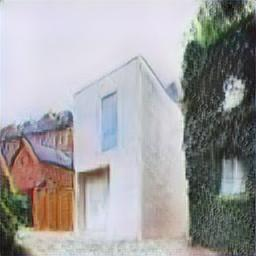

In [ ]:
paths = find_images(OUTPUT_DIR,"jpg")
path = paths[747]
print(path)
im = get_image(path)
im =array_to_img(im)
display(im)

### Training the model with an augmented dataset

After generating the images we can produce a new, augmented dataset for retraining. We would like to add the data to the existing train dataset, in order to have a more balanced distribution between different styles and categories.

In [ ]:
def part2_prepare_aug_dataset():
    #####
    # MODIFY SETTINGS HERE
    #####
    BATCH_SIZE = 64
    TRAIN_DS_PATH = os.path.join(pacs_path, "train-files/")
    TRAIN_TSV_PATH = os.path.join(pacs_path, "train-data.tsv")
    DERIVED_DS_PATH = os.path.join(pacs_path, "derived-files/")
    DERIVED_TSV_PATH = os.path.join(pacs_path, "derived-data.tsv")

    train2_ds = ClassificationDataset(TRAIN_TSV_PATH, TRAIN_DS_PATH, batch_size = BATCH_SIZE)
    train2_ds.add_data(DERIVED_TSV_PATH, DERIVED_DS_PATH)

    return train2_ds

train2_ds = part2_prepare_aug_dataset()

We can confirm the augmentation by looking at its distribution:

In [ ]:
part2_tally_samples(train2_ds)

(art_painting,dog): 63
(art_painting,elephant): 63
(art_painting,giraffe): 281
(art_painting,guitar): 60
(art_painting,horse): 230
(art_painting,house): 61
(art_painting,person): 61

(cartoon,dog): 60
(cartoon,elephant): 63
(cartoon,giraffe): 62
(cartoon,guitar): 171
(cartoon,horse): 61
(cartoon,house): 62
(cartoon,person): 62

(photo,dog): 60
(photo,elephant): 63
(photo,giraffe): 62
(photo,guitar): 60
(photo,horse): 61
(photo,house): 265
(photo,person): 261

(sketch,dog): 279
(sketch,elephant): 267
(sketch,giraffe): 60
(sketch,guitar): 59
(sketch,horse): 58
(sketch,house): 63
(sketch,person): 63



In [ ]:
print(len(train2_ds))
# train2_ds.tsv.iloc[2000:,:].head()
print(train2_ds.data_paths[2000:])

3041
['classify/derived-files/horseart_painting27.jpg', 'classify/train-files/pic_2199.jpg', 'classify/train-files/pic_1897.jpg', 'classify/train-files/pic_2691.jpg', 'classify/derived-files/houseart_painting1.jpg', 'classify/train-files/pic_676.jpg', 'classify/derived-files/housecartoon29.jpg', 'classify/train-files/pic_1827.jpg', 'classify/train-files/pic_1699.jpg', 'classify/train-files/pic_2128.jpg', 'classify/derived-files/housesketch46.jpg', 'classify/train-files/pic_588.jpg', 'classify/derived-files/guitarcartoon15.jpg', 'classify/derived-files/dogcartoon45.jpg', 'classify/train-files/pic_2893.jpg', 'classify/derived-files/horseart_painting31.jpg', 'classify/train-files/pic_1248.jpg', 'classify/derived-files/personphoto44.jpg', 'classify/derived-files/horsesketch30.jpg', 'classify/derived-files/dogphoto43.jpg', 'classify/train-files/pic_2582.jpg', 'classify/derived-files/guitarcartoon13.jpg', 'classify/derived-files/horsesketch36.jpg', 'classify/derived-files/housesketch4.jpg', 

Now we can train another classifier using the augmented data:

In [ ]:
model2_aug, loss2 = part2_setup()

In [ ]:
PART2_SAVE_PATH_2 = "/content/drive/MyDrive/comp4211_pa2/classify-augmentation.h5" # [Change to your own path]

# [Call your train function here, training on train2_ds]
part2_train(model2_aug, train2_ds, loss2, n_epochs = 100, save_interval = 10, save_path=PART2_SAVE_PATH_2, load_path=None)

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

In [ ]:
PART2_SAVE_PATH_2 = "/content/drive/MyDrive/comp4211_pa2/classify-augmentation.h5"
part2_train(model2_aug, train2_ds, loss2, n_epochs = 50, save_interval = 10, save_path=PART2_SAVE_PATH_2, load_path=PART2_SAVE_PATH_2)

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

In [ ]:
train_ds, test_ds = part2_prepare_datasets()

In [ ]:
model = load_model(PART2_SAVE_PATH_2)
print("Un-augmented training dataset:")
part2_evaluate(model, train_ds)

Un-augmented training dataset:
52/52 [==============================] - 14s 159ms/step
Accuracy: 1.0
Confusion matrix:
tf.Tensor(
[[262   0   0   0   0   0   0]
 [  0 256   0   0   0   0   0]
 [  0   0 265   0   0   0   0]
 [  0   0   0 150   0   0   0]
 [  0   0   0   0 210   0   0]
 [  0   0   0   0   0 251   0]
 [  0   0   0   0   0   0 247]], shape=(7, 7), dtype=int32)


In [ ]:
print("Test dataset:")
part2_evaluate(model, test_ds)

Test dataset:
86/86 [==============================] - 11s 132ms/step
Accuracy: 0.5134043097496033
Confusion matrix:
tf.Tensor(
[[147  41  38  38 127   3  13]
 [ 42 156  53  15  79   7  18]
 [ 79  19 282   4  29   5   7]
 [ 33  14  36 172  54  12  19]
 [104  33  14  17 190  10  14]
 [ 12  14  41  29  28 254   8]
 [ 38  23  38  23  75  19 197]], shape=(7, 7), dtype=int32)


Test the model for any performance changes. After that, feel free to explore on more ways to improve the model!